In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import ticker

import numpy as np
from collections import namedtuple
from scipy.stats import norm, norminvgauss, triang
from time import time
from tqdm.notebook import trange

In [2]:
############################
#### Physical constants ####
############################
PhysicalConstants = namedtuple('PhysicalConstants', ('g', 'rho_w', 'nu'))
CONST = PhysicalConstants(g=9.81,      # Acceleration due to gravity (m/s**2)
                          rho_w=1.025,  # Density of sea water (kg/m**3)
                          nu=1.358e-6, # Kinematic viscosity of sea water (m**2/s)
                         )

# Density distribution

In [3]:
# Normal-inverse Gaussian distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

mu    = 0.84
delta = 0.097
alpha = 75.1
beta  = 71.3
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norminvgauss.html
# for parameter convention in SciPy
pdf_density = norminvgauss(alpha*delta, beta*delta, mu, delta)
rvs_density = lambda N: pdf_density.rvs(N)

(0.8, 2.0)

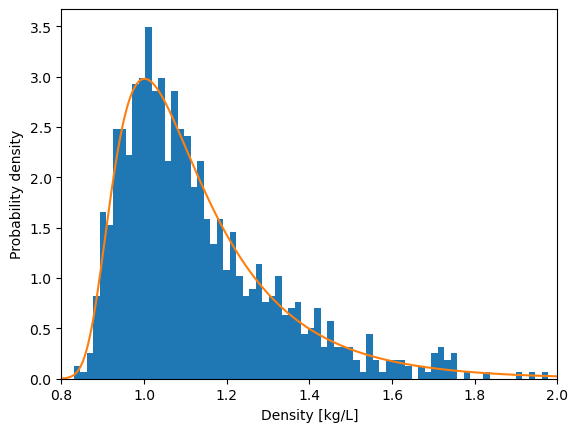

In [4]:
# Plot resulting distribution
rho = np.linspace(0.8, 2.0, 1000)
# Make a random sample and plot histogram
plt.hist(rvs_density(1000), bins=100, density=True)
plt.plot(rho, pdf_density.pdf(rho))
plt.xlabel('Density [kg/L]')
plt.ylabel('Probability density')
plt.xlim(0.8, 2.0)

# Size distribution

In [5]:
# Power law distribution, with parameters from
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379
# Cut-offs at 20 um and 5000 um.

# Un-normalised number distribution pdf
alpha = 1.6
powerlaw = lambda d : d ** (-alpha)
# Normalisation constant (calculated analytically from the integral)
P0 = 1/(-5/3*(5000**(-0.6) - 20**(-0.6)))
# Normalised volume distribution
pdf_size = lambda d: P0*powerlaw(d)

# Find CDF
F = lambda d: P0*(5/3)*(20**(-0.6) - d**(-0.6))
# Analytical inverse
F_inv = lambda u: (20**(-0.6) - 3*u/(5*P0))**(-5/3)

# Make a function to draw random samples,
# with the same signature as for density
rvs_size = lambda N: F_inv(np.random.random(N))

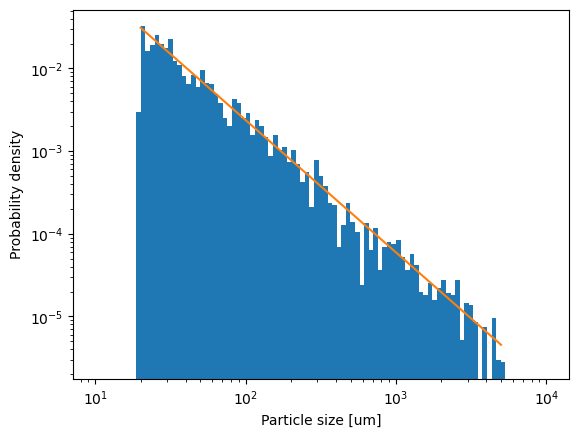

In [6]:
# Plot resulting distribution
size = np.linspace(20, 5000, 1000)
# Make a random sample and plot histogram
plt.hist(rvs_size(1000), bins=np.logspace(1, 4, 100), density=True)
plt.plot(size, pdf_size(size))
plt.xlabel('Particle size [um]')
plt.ylabel('Probability density')
plt.xscale('log')
plt.yscale('log')

# Shape distribution

In [7]:
# Distribution for Corey Shape Factor (CSF)
# total for all particles, included for completeness
# Note that we will actually use separate distributions
# for different shape categories, see below
# Parameters
f1, f2 = 0.06, 0.94
sigma1, sigma2 = 0.03, 0.19
mu1, mu2 = 0.08, 0.44
# Create two Gaussians
rv1 = norm(mu1, sigma1)
rv2 = norm(mu2, sigma2)
# Combine and normalise to compensate for truncation at 0 and 1
shape_distribution = lambda CSF : f1*rv1.pdf(CSF) / (rv1.cdf(1) - rv1.cdf(0)) + f2*rv2.pdf(CSF) / (rv2.cdf(1) - rv2.cdf(0))


# Distribution for Corey Shape Factor (CSF),
# separately for shape categories Fibre, Fragment, Bead, Film, and Foam
# All are symmetric, triangular distributions, with parameters from the supplementary material of
# https://pubs.acs.org/doi/pdf/10.1021/acs.estlett.9b00379

# c is a shape parameter, 0.5 = symmetric
c = 0.5
# loc is the leftmost point
# loc + c*scale is the peak
# loc + scale is the rightmost point
fibre_width  = triang(c, loc = 0.001, scale = 0.499)
fibre_height = triang(c, loc = 0.001, scale = 0.499)
fragment_width  = triang(c, loc = 0.1,  scale = 0.9)
fragment_height = triang(c, loc = 0.01, scale = 0.99)
bead_width  = triang(c, loc = 0.6,  scale = 0.4)
bead_height = triang(c, loc = 0.36, scale = 0.64)
film_width  = triang(c, loc = 0.1,   scale = 0.9)
film_height = triang(c, loc = 0.001, scale = 0.099)
foam_width  = triang(c, loc = 0.1,  scale = 0.9)
foam_height = triang(c, loc = 0.01, scale = 0.99)

# Function to generate random samples of shapes
def rvs_shape(N):
    category = np.zeros(N, dtype=np.int32)
    width  = np.zeros(N)
    height = np.zeros(N)
    # Select particle type
    xi = np.random.random(N)
    # Fill array based on value of xi
    # Probabilities are
    # Fibre    : 0.51
    # Fragment : 0.33
    # Bead     : 0.068
    # Film     : 0.056
    # Foam     : 0.036
    limits = np.cumsum([0.0, 0.51, 0.33, 0.068, 0.056, 0.036])
    width_pdfs  = [fibre_width,  fragment_width,  bead_width,  film_width,  foam_width ]
    height_pdfs = [fibre_height, fragment_height, bead_height, film_height, foam_height]
    for i in range(len(limits)-1):
        # Select particles in this category
        mask = (limits[i] <= xi) & (xi < limits[i+1])
        # Track particle type
        category[mask] = i
        # Draw width and height from relevant distribution
        width[mask]  = width_pdfs[i].rvs(np.sum(mask))
        height[mask] = height_pdfs[i].rvs(np.sum(mask))
        
    # Keep track of which particles are fibres
    fibre = xi < limits[1]
    # Make sure that height < width
    mask = width < height
    width[mask], height[mask] = height[mask], width[mask]
    # Calculate CSF (note that dimensions are scaled so that L=1)
    CSF = height / np.sqrt(width)
    return CSF, width, height, category

p(fibre) = 0.50853
p(fragment) = 0.3308
p(bead) = 0.06752
p(film) = 0.05702
p(foam) = 0.03613


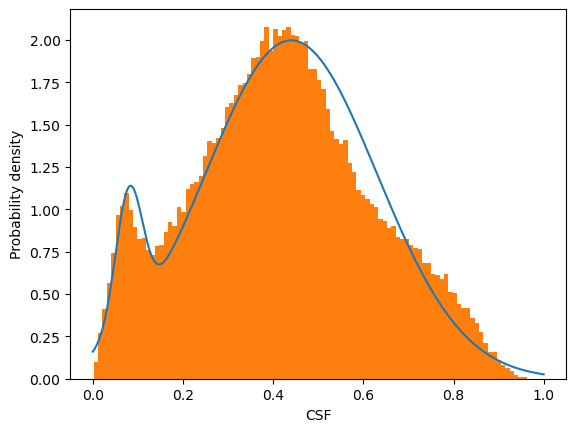

In [8]:
# Plot the complete CSF distribution found by Kooi & Koelsmans
CSF = np.linspace(0, 1, 1000)
plt.plot(CSF, shape_distribution(CSF))

# Make a random sample and plot histogram
CSF, w, h, cat = rvs_shape(100000)
plt.hist(CSF, bins=100, density=True)
plt.xlabel('CSF')
plt.ylabel('Probability density')

# Verify shape category probabilities
for i, shape in enumerate(['fibre', 'fragment', 'bead', 'film', 'foam']):
    print(f'p({shape}) = {np.sum(cat==i)/len(cat)}')


# Rise and settling speeds from Waldschläger & Schüttrumpf (2019)

In [9]:
# Rise speeds are calculated from drag coefficient, C_D
def rise_speed_CD(d, rho, CD):
    g_ = CONST.g*(CONST.rho_w - rho)/CONST.rho_w
    return np.sqrt(4*d*np.abs(g_)/(3*CD)) * np.sign(g_)


# Since C_D is a function of speed, the speed is found by an iterative procedure
def CD_iterator(CD_func, d, rho, CSF, rtol = 1e-3, maxiter = 100, return_speed=False, verbose=False, P=None):
    # Drag coefficients are given implicitly as a function of Re.
    # Solve for CD with iterative procedure,
    # start by guessing Re from Stokes' law.
    
    # Initial guess at a Reynolds number from Stokes' law
    Re0 = np.abs(stokes_law(d, rho)) * d / CONST.nu
    # Iterate until tolerance met, or maxiter
    Re = Re0
    for n in range(maxiter):
        # Calculate drag coefficient
        if P is None:
            CD = CD_func(Re, CSF)
        else:
            CD = CD_func(Re, CSF, P=P)
        # Calculate new Reynolds number
        Re = np.abs(rise_speed_CD(d, rho, CD)) * d / CONST.nu
        # Check for convergence
        if not np.any(np.abs(Re0 - Re)/Re0 > rtol):
            if verbose:
                print(f'Converged in {n} iterations')
            break
        Re0 = Re
    
    # Return either speed or drag coefficient, depending on kwarg
    if return_speed:
        return rise_speed_CD(d, rho, CD)
    else:
        return CD

def CD_pellet_sinking(Re, CSF):
    # Drag coefficient for sinking pellets from Eq. (10) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 3 / (CSF*Re**(1/3))

def CD_fibre_sinking(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (11) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 4.7/np.sqrt(Re) + np.sqrt(CSF)

def CD_pellet_rising(Re, CSF, P):
    # Drag coefficient for rising pellets from Eq. (12) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return (20/Re + 10/np.sqrt(Re) + np.sqrt(1.195 - CSF))*(6/P)**(1-CSF)

def CD_fibre_rising(Re, CSF):
    # Drag coefficient for sinking fibres from Eq. (13) in
    # https://pubs.acs.org/doi/pdf/10.1021/acs.est.8b06794
    return 10/np.sqrt(Re) + np.sqrt(CSF)

# Stokes' law, for comparison, and for initial guess at Re
def stokes_law(d, rho):    
    # Physical constants
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g     = CONST.g     # Acceleration of gravity (m/s**2)
    # reduced gravity
    g_    = g*(rho - rho_w) / rho_w
    # calculate and return velocity (positive upwards)
    return d**2 * g_ / (18*nu)

Converged in 7 iterations
Converged in 5 iterations


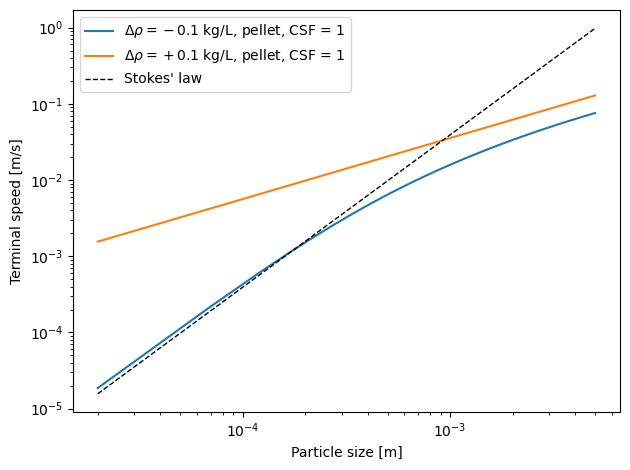

In [10]:
# Compare expression for pellets (using CSF=1) to Stokes' law

# Size range from 20 um to 5 mm
d = np.linspace(20e-6, 5e-3, 100)

# Positively buoyant
rho = CONST.rho_w - 0.1 # kg/L
# Get the drag coefficient
CD = CD_iterator(CD_pellet_rising, d, rho, CSF=1, P=1, verbose=True)
l = plt.plot(d, np.abs(rise_speed_CD(d, rho, CD)), label = f'$\Delta \\rho = -0.1$ kg/L, pellet, CSF = 1')

# Negatively buoyant
rho = CONST.rho_w + 0.1 # kg/L
# Get the drag coefficient
CD = CD_iterator(CD_pellet_sinking, d, rho, CSF=1, verbose=True)
l = plt.plot(d, np.abs(rise_speed_CD(d, rho, CD)), label = f'$\Delta \\rho = +0.1$ kg/L, pellet, CSF = 1')

plt.plot(d, stokes_law(d, rho), '--', c = 'k', lw = 1, label = f"Stokes' law")

plt.legend(loc = 'upper left')
plt.xlabel('Particle size [m]')
plt.ylabel('Terminal speed [m/s]')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('speed_comparison.png', dpi = 120)

# Function to combine all the above and generate random samples

In [11]:

#########################################################
#### Put everything together and draw random samples ####
#########################################################

def draw_random_speeds(Np):
    # Density
    rho = rvs_density(Np)

    # Size (longest dimension)
    l = rvs_size(Np) / 1e6 # Convert from micrometers to meters

    # Shape, and associated parameters
    # Note that h_ = h/l and w_ = w/l are normalised height and width
    # and we assume h <= w <= l
    CSF, w_, h_, cat = rvs_shape(Np)
    # Calculate real height and width
    h = l*h_
    w = l*w_
    # calculate equivalent spherical diameter
    # (assuming ellipsoid shape)
    d = (l*w*h)**(1.0/3)

    # Array to hold speeds
    v = np.zeros(Np)

    # Calculate speeds separately for fibres and other particles
    # Note that we use only the "rising" expressions from Waldschläger & Schüttrumpf
    # since the expressions for sinking seem to give unrealistic speeds compared to Stokes' law

    # Calculate speed for fibres
    v[cat==0] = CD_iterator(CD_fibre_rising, d[cat==0], rho[cat==0], CSF=CSF[cat==0], return_speed=True)
    # Calculate speed for non-fibres
    #P = np.random.randint(1, 7, size=np.sum(cat!=0))
    P = 3.5
    v[cat!=0] = CD_iterator(CD_pellet_rising, d[cat!=0], rho[cat!=0], CSF=CSF[cat!=0], return_speed=True, P=P)

    # Return generated random samples
    return v

# Speed distribution (linearly spaced bins)

Calculated 10000000 speeds in 8.551 seconds
Average velocity: -0.001228140114873792


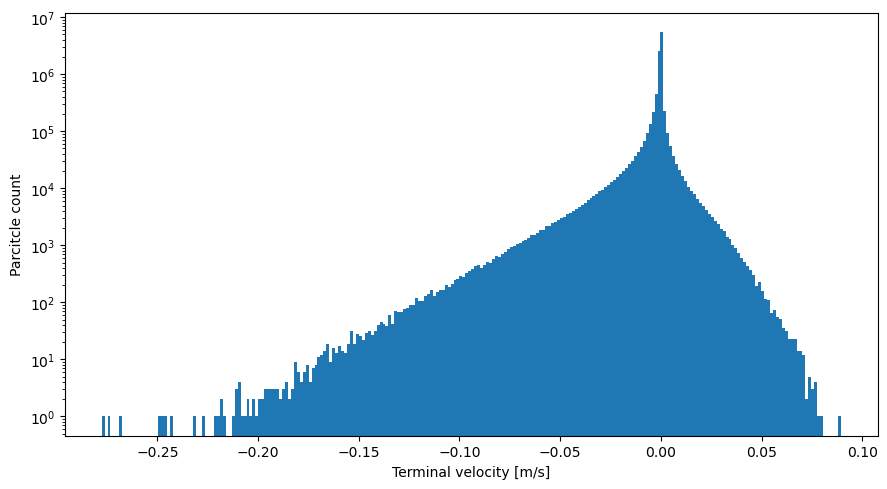

In [12]:
# Number of samples
Np = 10000000

tic = time()
v = draw_random_speeds(Np)
toc = time()

print(f'Calculated {Np} speeds in {toc-tic:.3f} seconds')
print(f'Average velocity: {np.mean(v)}')

# Plot a plain histogram of speeds
# (linearly spaced bins)
fig = plt.figure(figsize=(9,5))
_ = plt.hist(v, bins=250)
plt.yscale('log')
plt.ylabel('Parcitcle count')
plt.xlabel('Terminal velocity [m/s]')
plt.tight_layout()

# Speed distribution (logarithmically spaced bins)

Calculated 10000000 speeds in 8.254 seconds
Average velocity: -0.0012251534520113043


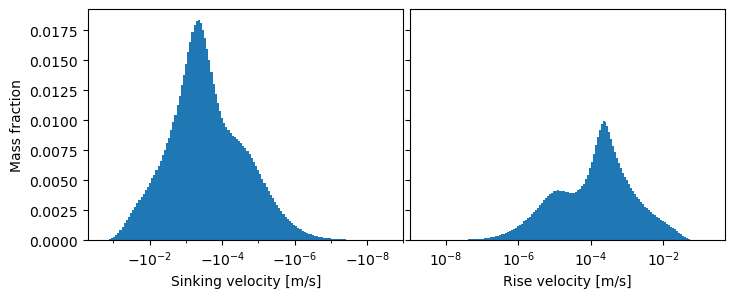

In [13]:
# Number of samples
Np = 10000000
# Generate random velocities
tic = time()
v = draw_random_speeds(Np)
toc = time()
print(f'Calculated {Np} speeds in {toc-tic:.3f} seconds')
print(f'Average velocity: {np.mean(v)}')


# Positive and negative velocities separately on log scale
fig, ax = plt.subplots(ncols=2, figsize=(7,3), sharey=True)

# Number of bins (must be even number)
Nk = 256
# Create positive and negative log-spaced bins
bins_positive = np.logspace(-8, np.log10(0.1), int(Nk/2) + 1)
bins_negative = np.logspace(-8, np.log10(0.3), int(Nk/2) + 1)
# Midpoints of bins
mids_positive =    np.sqrt(bins_positive[1:]*bins_positive[:-1])
mids_negative = -( np.sqrt(bins_negative[1:]*bins_negative[:-1]) )[::-1] # Flip sign and reverse order
bins_negative = -bins_negative[::-1] # Flip sign and reverse order

# Make separate histograms of positive and negative velocities
counts_negative = np.histogram(v, bins=bins_negative)[0]
counts_positive = np.histogram(v, bins=bins_positive)[0]

# plot negative velocities
wids = bins_negative[1:] - bins_negative[:-1]
ax[0].bar(mids_negative, counts_negative/Np, width=wids)
ax[0].set_xscale('symlog', linthresh=1e-10) # Use symlog to get negative logarithmic scale
ax[0].set_xlim(-5e-1, -1e-9)
ax[0].set_xticks([-1e-2, -1e-4, -1e-6, -1e-8])

# Plot positive velocities
wids = bins_positive[1:] - bins_positive[:-1]
ax[1].bar(mids_positive, counts_positive/Np, width=wids)
ax[1].set_xlim(1e-9, 5e-1)
ax[1].set_xscale('log')
ax[1].set_xticks([1e-8, 1e-6, 1e-4, 1e-2])

ax[0].set_ylabel('Mass fraction')
ax[0].set_xlabel('Sinking velocity [m/s]')
ax[1].set_xlabel('Rise velocity [m/s]')

plt.subplots_adjust(bottom=0.15, top=0.92, left=0.08, right=0.99, wspace=0.02)